<h3>VVI (Reusable Code)</h3>

In [28]:
from typing import TypedDict, Annotated, Dict,List
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

In [ ]:

load_dotenv()

True

In [6]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

In [ ]:
search_tool=TavilySearchResults(max_results=2)

In [8]:
tools=[search_tool]

In [9]:
llmLlama=ChatGroq(model="llama-3.1-8b-instant")

In [10]:
# illustrations
llmLlama.invoke(input="Who is SRT?")

AIMessage(content='SRT can refer to several entities, but some possible interpretations are:\n\n1. Dodge SRT: SRT stands for Street and Racing Technology, which is a high-performance division of the American automaker Dodge. It was previously a standalone company but is now a brand within Fiat Chrysler Automobiles (FCA). SRT is known for creating high-performance vehicles such as the Dodge Viper, Challenger SRT Hellcat, and Charger SRT Hellcat.\n\n2. Shane Richie-Turner: Shane Richie-Turner is a British actor who is also known as SRT.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 40, 'total_tokens': 157, 'completion_time': 0.19750073, 'prompt_time': 0.0022192, 'queue_time': 0.04964526, 'total_time': 0.19971993}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'finish_reason': 'stop', 'logprobs': None}, id='run--88aba3b1-6897-481c-ba31-24a86bbfb9fc-0', usage_metadata={'input_tokens': 40, 'output_tokens'

In [11]:
llm_with_tools=llmLlama.bind_tools(tools=tools)

In [ ]:
# illustration
t=llm_with_tools.invoke(input="What's the temperature at Kharagpur now?")
t

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '3qfy0q5r5', 'function': {'arguments': '{"query":"Kharagpur temperature now"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 289, 'total_tokens': 312, 'completion_time': 0.062565334, 'prompt_time': 0.024702863, 'queue_time': 0.066532607, 'total_time': 0.087268197}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--24363811-9a00-4b75-8c49-932e82a9aa87-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kharagpur temperature now'}, 'id': '3qfy0q5r5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 289, 'output_tokens': 23, 'total_tokens': 312})

In [13]:
# illustration
search_tool.invoke(t.tool_calls[0]['args']['query'])

[{'title': 'Kharagpur, West Bengal, India 14 day weather forecast',
  'url': 'https://www.timeanddate.com/weather/india/kharagpur/ext',
  'content': '| Thu Jan 22 |  | 81 / 56 °F | Sunny. | 79 °F | 5 mph | ↑ | 31% | 3% | 0.00" | 5 (Moderate) | 6:22 am | 5:23 pm |\n|  |  |  |  |  |  |  |  |  |  |  |  |  |\n ---  ---  ---  ---  ---  --- \n| \\ Updated Wednesday, January 7, 2026 8:54:02 pm Kharagpur time - Weather by CustomWeather, © 2026 | | | | | | | | | | | | | [...] | Sun Jan 18 |  | 79 / 55 °F | Sunny. | 77 °F | 7 mph | ↑ | 18% | 1% | 0.00" | 5 (Moderate) | 6:22 am | 5:21 pm |\n| Mon Jan 19 |  | 79 / 55 °F | Sunny. | 78 °F | 7 mph | ↑ | 22% | 1% | 0.00" | 5 (Moderate) | 6:22 am | 5:21 pm |\n| Tue Jan 20 |  | 80 / 56 °F | Sunny. | 78 °F | 5 mph | ↑ | 22% | 1% | 0.00" | 5 (Moderate) | 6:22 am | 5:22 pm |\n| Wed Jan 21 |  | 80 / 56 °F | Sunny. | 78 °F | 4 mph | ↑ | 26% | 1% | 0.00" | 5 (Moderate) | 6:22 am | 5:23 pm | [...] | Wed Jan 14 |  | 82 / 51 °F | Sunny. | 78 °F | 5 mph | ↑ | 21%

In [14]:
def agent(state:ChildState):
    state["messages"]=llm_with_tools.invoke(input=state["messages"])
    return state

In [15]:
def tools_router(state: ChildState):
    print(f"State prior to tool calling: {state}\n")
    last_message=state["messages"][-1]
    if (hasattr(last_message,"tool_calls")) and len(last_message.tool_calls)>0:
        return "tool_node"
    else:
        return "end"

In [16]:
tool_node=ToolNode(tools=tools)

In [17]:
subGraph=StateGraph(state_schema=ChildState)

In [18]:
subGraph.add_node(node="agent",action=agent)

In [19]:
subGraph.add_node(node="tool_node", action=tool_node)

In [20]:
subGraph.add_conditional_edges(source="agent",path=tools_router,
                               path_map={"tool_node":"tool_node","end":END}
                              )

In [21]:
subGraph.add_edge(start_key="tool_node",end_key="agent")

In [22]:
subGraph.set_entry_point(key="agent")

In [23]:
search_app=subGraph.compile()

In [24]:
print(search_app.get_graph().print_ascii())

          +-----------+           
          | __start__ |           
          +-----------+           
                 *                
                 *                
                 *                
            +-------+             
            | agent |             
            +-------+.            
           **         ..          
         **             ..        
        *                 .       
+-----------+         +---------+ 
| tool_node |         | __end__ | 
+-----------+         +---------+ 
None


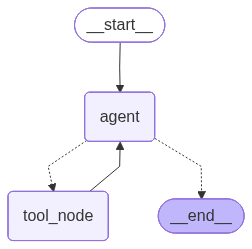

In [25]:
display(Image(data=search_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [26]:
response=search_app.invoke(input={"messages":"How is the weather in Chennai?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='3439f064-0475-4e75-ae00-cb350463457d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cvqzd0mf4', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.049784979, 'prompt_time': 0.02910545, 'queue_time': 0.055419219, 'total_time': 0.078890429}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--074f3964-3544-4100-835d-bf5ffe3b5225-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'cvqzd0mf4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306})]}


In [27]:
response

{'messages': [HumanMessage(content='How is the weather in Chennai?', additional_kwargs={}, response_metadata={}, id='3439f064-0475-4e75-ae00-cb350463457d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cvqzd0mf4', 'function': {'arguments': '{"query":"Chennai weather today"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 285, 'total_tokens': 306, 'completion_time': 0.049784979, 'prompt_time': 0.02910545, 'queue_time': 0.055419219, 'total_time': 0.078890429}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f757f4b0bf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--074f3964-3544-4100-835d-bf5ffe3b5225-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Chennai weather today'}, 'id': 'cvqzd0mf4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 21, 'total_tokens': 306}),
  ToolMessage(content='[{"ti

<h3>Shared Schema, direct embedding</h3>

In [29]:
class ParentState(TypedDict):
    messages:Annotated[List[BaseMessage], add_messages]

In [30]:
# Create a parent graph
parent_graph=StateGraph(state_schema=ParentState)

In [31]:
# Add the subgraph as a node
parent_graph.add_node(node="search_agent",action=search_app)

In [32]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [33]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [34]:
# Compile the parent graph
parent_app=parent_graph.compile()

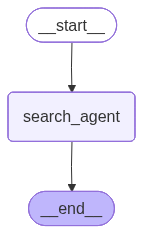

In [35]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [36]:
response=parent_app.invoke(input={"messages":"How is the weather in Kolkata?"})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='0c023536-6985-4059-8725-552c50e721e4'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4gw7red8s', 'function': {'arguments': '{"query":"Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.046409464, 'prompt_time': 0.016996553, 'queue_time': 0.055618737, 'total_time': 0.063406017}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--07e9cf13-d0ff-4fa8-95ef-aa507a078d6d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': '4gw7red8s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

State prio

In [37]:
response

{'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='0c023536-6985-4059-8725-552c50e721e4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4gw7red8s', 'function': {'arguments': '{"query":"Kolkata weather"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.046409464, 'prompt_time': 0.016996553, 'queue_time': 0.055618737, 'total_time': 0.063406017}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--07e9cf13-d0ff-4fa8-95ef-aa507a078d6d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Kolkata weather'}, 'id': '4gw7red8s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305}),
  ToolMessage(content='[{"title": "Kolk

<h3>Different Schema (Invoke with Transformation)</h3>

In [38]:
# define parent graph with a different scheme
class QueryState(TypedDict):
    query: str
    response: str

In [39]:
# Function to invoke a Subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to Subgraph schema
    subgraph_input={"messages":[state['query']]}
    # Invoke the subgraph
    subgraph_result=search_app.invoke(input=subgraph_input)

    state['response']=subgraph_result["messages"][-1].content
    return state

In [40]:
# Create a parent graph
parent_graph=StateGraph(state_schema=QueryState)

In [41]:
# Add transformation node that invokes subgraph
parent_graph.add_node(node="search_agent",action=search_agent)

In [42]:
# connect the flow
parent_graph.add_edge(start_key=START,end_key="search_agent")

In [45]:
# connect the flow
parent_graph.add_edge(start_key="search_agent",end_key=END)

In [43]:
# Compile the parent graph
parent_app=parent_graph.compile()

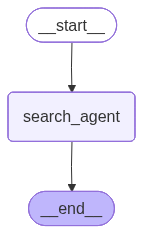

In [44]:
display(Image(data=parent_app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [45]:
response=parent_app.invoke(input={"query":"How is the weather in Kolkata?","response":""})

State prior to tool calling: {'messages': [HumanMessage(content='How is the weather in Kolkata?', additional_kwargs={}, response_metadata={}, id='9e19e029-6a39-40f8-a5d2-b5be8c989b67'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'w1nfemndt', 'function': {'arguments': '{"query":"weather in Kolkata"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 285, 'total_tokens': 305, 'completion_time': 0.038976728, 'prompt_time': 0.022122783, 'queue_time': 0.057255597, 'total_time': 0.061099511}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0b87961d-9745-42c4-b722-83ddb30792ab-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Kolkata'}, 'id': 'w1nfemndt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 285, 'output_tokens': 20, 'total_tokens': 305})]}

Stat

In [46]:
response

{'query': 'How is the weather in Kolkata?',
 'response': 'The current weather in Kolkata is expected to be mostly cool with a temperature fluctuating from minimum at 50°F to its maximum at 84°F.'}